# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import numpy as np
from tqdm import tqdm

from dask.distributed import Client, LocalCluster, progress, fire_and_forget
from dask import delayed

mpl.style.use('default')
#%matplotlib notebook
%matplotlib inline

# Setting up Dask cluster
To connect to the Dask dashboard use ssh portforwarding: http://distributed.dask.org/en/latest/web.html#id1

cluster = LocalCluster(processes=False, n_workers=1)
client=Client(cluster, processes=True)
client

# Tensorflow backend initialization

In [2]:
"""
Setup multi GPU usage

Example usage:
model = Sequential()
...
multi_model = multi_gpu_model(model, gpus=num_gpu)
multi_model.fit()

About memory usage:
https://stackoverflow.com/questions/34199233/how-to-prevent-tensorflow-from-allocating-the-totality-of-a-gpu-memory
"""
import tensorflow as tf
from keras.utils.training_utils import multi_gpu_model
from tensorflow.python.client import device_lib

# IMPORTANT: Tells tf to not occupy a specific amount of memory
from keras.backend.tensorflow_backend import set_session  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU  
sess = tf.Session(config=config)  
set_session(sess)  # set this TensorFlow session as the default session for Keras.


# getting the number of GPUs 
def get_available_gpus():
   local_device_protos = device_lib.list_local_devices()
   return [x.name for x in local_device_protos if x.device_type    == 'GPU']
num_gpu = len(get_available_gpus())
print('Amount of GPUs available: %s' % num_gpu)

/opt/jupyterhub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


Amount of GPUs available: 4


# Function definitions

In [3]:
def create_corr_matrix(df, dwelling_id, annot):
    """
    Pearson correlation coefficient matrix. 
    The Pearson correlation coefficient is a measure of the linear correlation between two variables.
    """
    plt.clf()
    
    corr = df.corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True

    if annot:
        fig, ax = plt.subplots(figsize=(25,25))
    else:
        fig, ax = plt.subplots()

    fig = sns.heatmap(corr, mask=mask, square=False, cmap='RdYlGn', annot=annot, ax=ax, 
                cbar_kws={'label':'Pearson correlation coefficient [-]'})

    fig.set_title('Correlation matrix of dwelling ID: '+dwelling_id)
    fig.tick_params(axis='x', rotation=90)
    fig.tick_params(axis='y', rotation=0)

    fig = fig.get_figure()
    fig.tight_layout()
    fig.show()
    
    print('Saving heatmap')
    #fig.savefig('//datc//opschaler//EDA//Pearson_corr//' + dwelling_id + '.png', dpi=300)
    return fig


def reduce_memory(df):
    """
    Reduces memory footprint of the input dataframe.
    Changes float64 columns to float32 dtype.
    """
    columns = df.columns
    memory_before = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB

    for column in tqdm(columns):
        if df[column].dtype == 'float64':
            df[column] = df[column].astype('float32')
        
    memory_after = df.memory_usage(deep=False).sum() / 2**30 # convert bytes to GB
    print('Memory uasge reduced from %.3f GB to %.3f GB' % (memory_before, memory_after))
    
    return df


def resample_df(df, sample_rate, combine_all_dwellings=False):
    """
    Resampled a (un)processed dataframe to the specified sample_rate.
    Input is a (un)processed df.
    Input df may also be multiple dwelling dfs combined.
    Sample rate must be a string. 
    For example '1H', '1D', '60s'.
    
    Combine all dwellings: resamples the df and ignores the fact that there are unique dwellings.
    
    TODO: add std to ePower, gasPower when combine_all_dwellings=False
    """
    def resample_dwelling(df, sample_rate, dwelling_id):
        df = df.resample(sample_rate).mean() # resample to rest by mean
        df['dwelling'] = dwelling_id
        return df
        
                      
    resampled_dwellings = []
    
    if combine_all_dwellings: # Ignore dwelling_ids
        df = df.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Drop columns because they are meaningless when ignoring dwelling ids
        resampled_df = resample_dwelling(df, sample_rate, 'All dwellings')
        resampled_dwellings.append(resampled_df)
    else:
        dwellings = df['dwelling'].unique() # Get dwelling ids
        for dwelling_id in tqdm(dwellings):
            dwelling_df = df[df['dwelling'] == dwelling_id] # Get the data from only that dwelling_id
            resampled_dwelling = resample_dwelling(dwelling_df, sample_rate, dwelling_id)
            resampled_dwellings.append(resampled_dwelling)
    
    resampled_df = pd.concat(resampled_dwellings)
    
    return resampled_df

# Preparing dataframe for preprocessing

In [4]:
%%time
#df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//P01S01W8655_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = pd.read_csv('//datc//opschaler//combined_gas_smart_weather_dfs//processed//all_dwellings_combined_hour.csv', delimiter='\t', parse_dates=['datetime'])
df = df.set_index(['datetime'])
df = df.dropna()

# Get an hour dataframe
h = resample_df(df, 'D') # For some reason this makes df equal h, so it changes the df variable being read in at the start...
h['hour'] = h.index.hour #create column containing the hour
h['dayofweek'] = h.index.dayofweek

100%|██████████| 51/51 [00:00<00:00, 132.45it/s]

CPU times: user 840 ms, sys: 112 ms, total: 953 ms
Wall time: 883 ms


In [5]:
h.head()

,eMeter,eMeterReturn,eMeterLow,eMeterLowReturn,ePower,ePowerReturn,gasMeter,DD,DR,FF,...,T,T10,TD,U,VV,WW,gasPower,dwelling,hour,dayofweek
datetime,,,,,,,,,,,,,,,,,,,,,
2017-03-07,626.292503,0.0,359.521881,0.0,282.870693,0.0,307.980381,265.558334,0.000000,3.374167,...,7.050000,6.966667,4.175000,81.541667,21814.583496,2.125000,0.250999,P01S01W7548,0,1
2017-03-08,629.484212,0.0,360.328082,0.0,356.053646,0.0,310.351919,213.084098,224.500000,5.064417,...,6.746875,5.942014,5.512361,91.376389,12635.340159,27.159722,0.107499,P01S01W7548,0,2
2017-03-09,636.767047,0.0,361.247515,0.0,344.359775,0.0,312.175391,251.361233,39.913043,5.038065,...,8.107826,7.240290,6.275217,88.585507,12942.542630,17.879710,0.020870,P01S01W7548,0,3
2017-03-10,643.745875,0.0,362.233957,0.0,274.205846,0.0,312.732838,192.034376,0.000000,2.295215,...,6.000347,4.032222,2.408819,79.414583,17732.680524,9.366667,0.050125,P01S01W7548,0,4
2017-03-11,647.536987,0.0,365.092253,0.0,289.915380,0.0,313.870837,128.449862,0.000000,2.373917,...,8.258403,6.653681,3.016389,69.589583,24022.708252,1.887500,0.023083,P01S01W7548,0,5


## Get a proper hourly dataframe

Saving heatmap


/opt/jupyterhub/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


<Figure size 432x288 with 0 Axes>

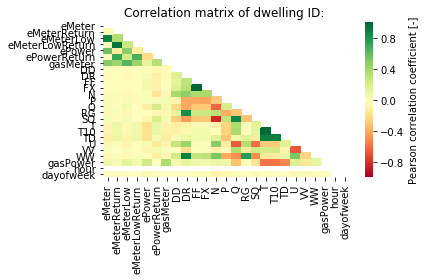

In [6]:
fig = create_corr_matrix(h, '', False)

## Select data we want

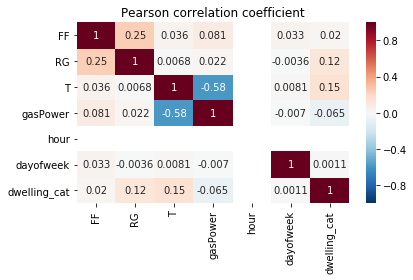

In [7]:
data = h
data = data.drop(['eMeter', 'eMeterReturn', 'eMeterLow', 'eMeterLowReturn', 'gasMeter'], axis=1) # Not needed
data = data.drop(['WW', 'VV', 'P', 'DR', 'SQ', 'TD', 'T10', 'FX'], axis=1) # Drop weather columns which contain correlated information, keep only one type

"""
Set dwelling id as category data. 
This way all data of one dwelling is in one category. 
Might lateron expand this to take house characteristics into account (The Excel data?), once this gets decent results)
"""
data['dwelling_cat'] = data['dwelling'].astype('category').cat.codes

#sns.heatmap(data.corr(), annot=True)

data = data.drop(['ePower', 'ePowerReturn'], axis=1) # Drop if want to predict gasPower

# Drop columns with that have a |corr| > 0.1 with T
data = data.drop(['U', 'N', 'Q', 'DD'], axis=1)

#data = data[data['gasPower'] > 0] #filter data based on condition
data = data.dropna()
magnitude = 1
data['gasPower'] = data['gasPower']*10**magnitude

sns.heatmap(data.corr(), annot=True)
plt.title('Pearson correlation coefficient')
plt.tight_layout()
#plt.savefig('figures//NN corr heatmap.png', dpi=1000)

# EDA

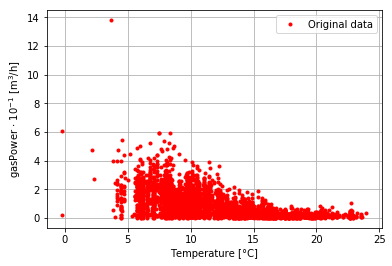

In [8]:
plt.plot(data['T'], data['gasPower'], '.', color='r', label='Original data')
plt.grid()
plt.xlabel('Temperature [°C]')
plt.ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)
plt.legend()

# Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

seed = 42

X = data.drop(['gasPower', 'dwelling'], axis=1)
#X = data[['T']] # Only select T column
print('X columns final: %s' % list(X.columns))
#sns.heatmap(X.corr(), annot=True)

y = data[['gasPower']]

X columns final: ['FF', 'RG', 'T', 'hour', 'dayofweek', 'dwelling_cat']


# train_test_split the data

In [10]:
X = np.array(X).reshape(-1, len(X.columns))
y = np.array(y).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=seed)

# fit scalers to training data
scalerX = StandardScaler(with_mean=True, with_std=True).fit(X_train)
scalery = StandardScaler(with_mean=True, with_std=True).fit(y_train)

# Normalize X arrrays
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test)

# Get test data in the correct shape and format
y_train = np.array(y_train).reshape(-1,1) #reshape if y_train is not scaled, transforming should not be needed
y_test = np.array(y_test).reshape(-1,1)

def stats(ndarray):
    shape = ndarray.shape
    var = ndarray.var()
    mean = ndarray.mean()
    std = ndarray.std()
    min_ = ndarray.min()
    max_ = ndarray.max()
    return shape, var, mean, std, min_, max_

print('')
print('X_train -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_train)))
print('X_test -> \t shape: %s \t var: %.1f \t mean: %.1f \t std: %.1f, \t min: %.1f \t max: %.1f'% (stats(X_test)))
print('')
print('y_train -> \t shape: %s \t var: %.1E \t mean: %.1E  std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_train)))
print('y_test -> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E, \t min: %.1E \t max: %.1E'% (stats(y_test)))


X_train -> 	 shape: (2292, 6) 	 var: 0.8 	 mean: -0.0 	 std: 0.9, 	 min: -2.9 	 max: 12.6
X_test -> 	 shape: (2292, 6) 	 var: 0.8 	 mean: 0.0 	 std: 0.9, 	 min: -2.9 	 max: 7.9

y_train -> 	 shape: (2292, 1) 	 var: 7.7E-01 	 mean: 8.2E-01  std: 8.8E-01, 	 min: 0.0E+00 	 max: 1.4E+01
y_test -> 	 shape: (2292, 1) 	 var: 7.9E-01 	 mean: 8.3E-01 	 std: 8.9E-01, 	 min: 0.0E+00 	 max: 6.1E+00


# Predict gasPower with most other variables

# Create the model

In [11]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.recurrent import LSTM
from keras.layers import Dense, Conv1D, MaxPool2D, Flatten, Dropout
from keras.callbacks import EarlyStopping, TensorBoard
from keras.optimizers import Adam, SGD, Nadam
from time import time
from livelossplot import PlotLossesKeras

# Model node size & layer size scanner

In [12]:
def compile_model(model):
    # Compile model
    model = multi_gpu_model(model, gpus=num_gpu)
    model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')
    return model


def generate_models(first_layer_sizes, deep_layers, deep_layer_sizes, dropouts, activations, optimizers):
    """
    TODO: Add model, first layer size, deep layers, deep layer size to a dict.
    
    Generate different models, depending on input variables. 
    Loops works from the inside out, in comparisment to a regular model. 
    For example with input: 
    first_layer_sizes = [8, 16]
    deep_layers = [0, 4, 8, 16]
    deep_layer_sizes = [8, 16, 32, 64]
    dropouts = [0.5]
    activations = ['relu']
    optimizers = ['adam']
    
    Will do create models with:
    model i output:
    first_layer_size, deep_layers, deep_layer_size
    
    first model -> 8 0 8
    second model -> 8 1 8
    third model -> 8 2 8
    ...
    16 0 8
    16 1 8
    16 3 8
    ...
    32 0 8
    32 1 8
    32 2 8
    ...
    64 0 8
    64 1 8
    64 2 8
    ...
    8 0 16
    8 1 16
    8 2 16
    ...
    16 0 16
    16 1 16
    16 2 16
    ...

    This will be more clear if you look at the prints being generated while you run this function. 
    """
    N = len(deep_layers)*len(deep_layer_sizes)*len(first_layer_sizes)*len(dropouts)*len(activations)*len(optimizers)
    print('Models to compile: %s' % N)
    N = 0
    
    models = []
    info_first_layer_sizes = []
    info_deep_layers = []
    info_deep_layer_sizes = []
    info_dropouts = []
    info_activations = []
    info_optimizers = []
    
    for deep_layer_size in deep_layer_sizes:
        #print('selected deep_layer_size: %s' % deep_layer_size)  
        for first_layer_size in first_layer_sizes:  
            #print('selected first_layer_size: %s' % first_layer_size)  
            for layers in deep_layers:
                for d in dropouts:
                    for a in activations:
                        for o in optimizers:
                            print('model: %s \t first_layer_size: %s \t deep layers: %s \t deep_layer_size: %s \t' % (N, first_layer_size, layers, deep_layer_size))
                            model = Sequential()

                            # Input layer
                            model.add(Dense(first_layer_size, input_shape=(X_train.shape[1],), kernel_initializer='normal'))
                            model.add(Activation('relu'))
                            model.add(Dropout(d, seed=seed))
                
                            # Add deep layers
                            for j in range(layers):
                                #print('Added deep layer: %s' % j)
                                model.add(Dense(deep_layer_size, kernel_initializer='normal'))
                                model.add(Activation('relu'))
                                model.add(Dropout(d, seed=seed))

        
                            # Output layer
                            model.add(Dense(1, kernel_initializer='normal'))
                            model.add(Activation('linear'))
                
                            #model = multi_gpu_model(model, gpus=num_gpu)
                            #model.compile(loss='mean_squared_error', metrics=['mse'], optimizer='adam')
                            model = multi_gpu_model(model, gpus=num_gpu)
                            model.compile(loss='mean_squared_error', metrics=['mse'], optimizer=o)
                            #model = delayed(compile_model)(model)
                            #model = model.persist()
                            models.append(model)
                
                            # Append erchitecture info to lists
                            info_first_layer_sizes.append(first_layer_size)
                            info_deep_layers.append(layers) # Amount of deep layers
                            info_deep_layer_sizes.append(deep_layer_size)
                            info_dropouts.append(d)
                            info_activations.append(a)
                            info_optimizers.append(o)

                            N +=1
                            #print('------------------------------------------------model compiled')
                
    # Create model architecture df, list of lists to df
    headers = ['First layer size', 'Amount of deep layers', 'Deep layer sizes', 'Dropout', 'Activation', 'Optimizer']
    z = [info_first_layer_sizes, info_deep_layers, info_deep_layer_sizes, info_dropouts, info_activations, info_optimizers]
    df = pd.DataFrame(z)
    df = df.T # Take the transpose
    df.columns = headers
    df['Model number'] = df.index
        
    return models, df

# Scan layer & node sizes

In [13]:
%%time

first_layer_sizes = [128]
deep_layers = [2, 3]
deep_layer_sizes = [32, 64]
#dropouts = np.linspace(0, 1, 10)
dropouts = [0.1]
activations = ['relu', 'sigmoid']
optimizers = ['adam', 'nadam', 'sgd']

models, architectures = generate_models(first_layer_sizes, deep_layers, deep_layer_sizes, dropouts, activations, optimizers)

Models to compile: 24
model: 0 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 32 	
model: 1 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 32 	
model: 2 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 32 	
model: 3 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 32 	
model: 4 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 32 	
model: 5 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 32 	
model: 6 	 first_layer_size: 128 	 deep layers: 3 	 deep_layer_size: 32 	
model: 7 	 first_layer_size: 128 	 deep layers: 3 	 deep_layer_size: 32 	
model: 8 	 first_layer_size: 128 	 deep layers: 3 	 deep_layer_size: 32 	
model: 9 	 first_layer_size: 128 	 deep layers: 3 	 deep_layer_size: 32 	
model: 10 	 first_layer_size: 128 	 deep layers: 3 	 deep_layer_size: 32 	
model: 11 	 first_layer_size: 128 	 deep layers: 3 	 deep_layer_size: 32 	
model: 12 	 first_layer_size: 128 	 deep layers: 2 	 deep_layer_size: 64 	
model: 13 	 f

In [ ]:
architectures.head()

,First layer size,Amount of deep layers,Deep layer sizes,Dropout,Activation,Optimizer,Model number
0,128,2,32,0.1,relu,adam,0
1,128,2,32,0.1,relu,nadam,1
2,128,2,32,0.1,relu,sgd,2
3,128,2,32,0.1,sigmoid,adam,3
4,128,2,32,0.1,sigmoid,nadam,4


# Fit the models

To load tensorboard follow these steps in the datascience terminal:  
`cd notebooks/KB-74-OPSCHALER/Personal_folder/Brian/Keras`  
`tensorboard --logdir=.logs/ --port=6009`  
Then ssh port-forward in your own terminal:  
`ssh -NL 6009:localhost:6009 16011015@datascience.hhs.nl`  


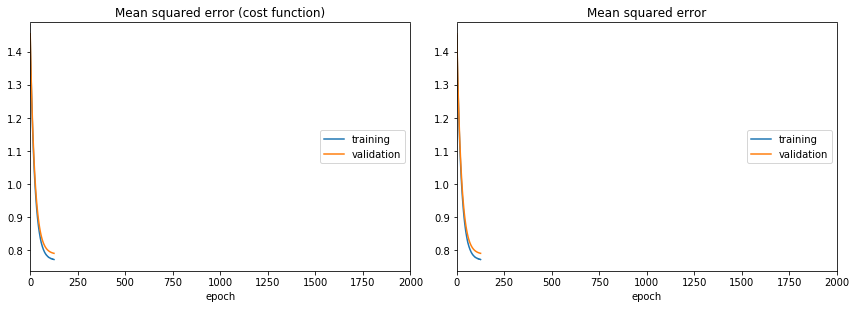

Epoch 127/2000


In [ ]:
from datetime import datetime
now = datetime.now()

histories = []

N_epochs = 2000

# Use dask on this?
for i, model in enumerate(tqdm(models)):
    df = architectures.iloc[i,:]
    model_name = ("| model: %s (layers x nodes) 1x%s - %sx%s - 1x1 | %s | %s | %s" % (df[6], df[0], df[1], df[2], df[3], df[4], df[5])) # Give the model a name, containing architecture information
    tensorboard = TensorBoard(log_dir=".logs/"+now.strftime("%Y%m%d-%H%M%S")+"/{}".format(model_name)) # save model in 'now' dir.
    early_stopping_monitor = EarlyStopping(patience=500)
    
    history = model.fit(X_train, y_train, batch_size=int(len(X_train)), 
                epochs=N_epochs, verbose=3, validation_data=(X_test, y_test),
                callbacks=[early_stopping_monitor, PlotLossesKeras(), tensorboard])
    
    histories.append(history)

# Plot the results

In [ ]:
# Show results
for i, history in enumerate(histories):
    plt.subplot(1,2,1)
    plt.title('val_mean_squared_error')
    plt.plot(history.history['val_mean_squared_error'], label=i)
    plt.xlabel('epoch')
    plt.tight_layout()
    
    plt.subplot(1,2,2)
    plt.title('mean_squared_error')
    plt.plot(history.history['mean_squared_error'], label=i)
    plt.xlabel('epoch')
    plt.tight_layout()
    
    #plt.legend()

In [ ]:
final_scores = []
for i in tqdm(range(len(histories))):
    model = models[i]
    final_score = model.fit(X_test, y_test, verbose=0).history['mean_squared_error'][0]
    final_scores.append(final_score)

plt.plot(final_scores, '.', color='r')
plt.ylabel('mean squared error')
plt.xlabel('model number [-]')
plt.title('Validation MSE of models at %sth epoch' % N_epochs)
plt.grid()

plt.savefig('scan results', dpi=1000)

# Update the model architecture dataframe

In [ ]:
architectures['Final MSE'] = final_scores
#architectures.to_csv('architectures_all_dwellings_day_2.csv', sep='\t')
architectures

In [ ]:
architectures[architectures['Final MSE'] < 0.48]

# Plot insights

In [ ]:
df = architectures

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(df['First layer size'], df['Final MSE'], '.', color='r', alpha=1, label='Real')
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Input layer size [-]')
axarr[0, 0].set_ylabel('MSE')

axarr[0, 1].plot(df['Amount of deep layers'], df['Final MSE'], '.', color='r', alpha=1, label='Real')
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Amount of deep layers [-]')
axarr[0, 1].set_ylabel('MSE')

axarr[1, 0].plot(df['Deep layer sizes'], df['Final MSE'], '.', color='r', alpha=1, label='Real')
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Deep layer sizes [-]')
axarr[1, 0].set_ylabel('MSE')

axarr[1, 1].plot(df['Model number'], df['Final MSE'], '.', color='r', alpha=1, label='Real')
axarr[1, 1].grid()
axarr[1, 1].set_xlabel('Model number [-]')
axarr[1, 1].set_ylabel('MSE')


fig.suptitle('Deep neural network structure results after %s epochs' % N_epochs, fontsize = 14)
fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.93) # Adjust title spacing at the top

In [ ]:
sns.pairplot(df)

# Plot results

In [ ]:
# model number to select
N = 0


# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = models[N].predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
FF = x_pred[:,0]
RG = x_pred[:,1]
T = x_pred[:,2]

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 0].plot(T, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(T, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

axarr[0, 1].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(RG, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[0, 1].plot(RG, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)


axarr[1, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[1, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

fig.delaxes(axarr[1, 1])

mse = models[N].evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

#fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s $\cdot$ 10$^{-%s}$' % (mse_val, mse_power), fontsize = 14)
fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[1, 0].legend(loc='lower left', bbox_to_anchor= (1.25, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)
print('FINISHED')

In [ ]:
# Complete plot, commented out
# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
DD = x_pred[:,0]
FF = x_pred[:,1]
N = x_pred[:,2]
Q = x_pred[:,3]
RG = x_pred[:,4]
T = x_pred[:,5]
U = x_pred[:,6]

fig, axarr = plt.subplots(3,3)

axarr[0, 0].plot(data['DD'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[0, 0].plot(DD, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(DD, y_pred, 'x', color='b', label='X_test, y_predict', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Wind direction $DD$ [$\degree$] \n (10 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[0, 1].plot(data['N'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(N, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 1].plot(N, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Total cloud coverage $N$ [octa]')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[0, 2].plot(data['Q'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 2].plot(Q, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 2].plot(Q, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 2].grid()
axarr[0, 2].set_xlabel('global radiation $Q$ [W/m$^2$] \n (10 min mean)')
axarr[0, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 0].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 0].plot(RG, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(RG, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 1].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 1].plot(T, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[1, 1].plot(T, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[1, 1].grid()
axarr[1, 1].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[1, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[1, 2].plot(data['U'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[1, 2].plot(U, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 2].plot(U, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[1, 2].grid()
axarr[1, 2].set_xlabel('Relative humidity at 1,5 m $U$ [%] \n (1 min mean)')
axarr[1, 2].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

axarr[2, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[2, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[2, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[2, 0].grid()
axarr[2, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[2, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-2}$ [m$^3$/h]')

fig.delaxes(axarr[2, 1])
fig.delaxes(axarr[2, 2])

mse = multi_model.evaluate(X_test, y_test)[0]
mse_val = str(mse)[:4]
mse_power = str(mse)[-1:]

fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s' % (mse_val), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()



fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[2, 0].legend(loc='lower left', bbox_to_anchor= (2, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
fig.savefig('DDN last result.png', dpi=1200)

In [ ]:
# Multi variate regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


model = LinearRegression()
model.fit(X_train, y_train)
model.score(X_test, y_test) # Still sucks

In [ ]:
model

In [ ]:
# model number to select
N = 35


# X_test is already transformed
x_pred = X_test
#x_pred = scalerX.transform(x_pred)

y_pred = model.predict(x_pred)


print('x_pred scaled-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

x_pred = scalerX.inverse_transform(x_pred)
print('x_pred inverse-> \t shape: %s \t var: %.1E \t mean: %.1E \t std: %.1E'% (x_pred.shape, x_pred.var(), x_pred.mean(), x_pred.std()))

# select test variables
FF = x_pred[:,0]
RG = x_pred[:,1]
T = x_pred[:,2]

fig, axarr = plt.subplots(2,2)


axarr[0, 0].plot(data['T'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 0].plot(T, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[0, 0].plot(T, y_pred, 'x', color='b', label='Predicted', alpha=0.3)
axarr[0, 0].grid()
axarr[0, 0].set_xlabel('Temperature at 1,5 m $T$ [$\degree$C] \n (1 min mean)')
axarr[0, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

axarr[0, 1].plot(data['RG'], data['gasPower'], '.', color='r', alpha=0.3, label='Real')
axarr[0, 1].plot(RG, y_test, 'v', color='g', alpha=0.3, label='X_test, y_test')
axarr[0, 1].plot(RG, y_pred, 'x', color='b', alpha=0.3, label='Predicted')
axarr[0, 1].grid()
axarr[0, 1].set_xlabel('Rain intensity $RG$ [mm/h] \n (10 min mean)')
axarr[0, 1].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)


axarr[1, 0].plot(data['FF'], data['gasPower'], '.', color='r', alpha=0.3, label='All real data')
axarr[1, 0].plot(FF, y_test, 'v', color='g', label='X_test, y_test', alpha=0.3)
axarr[1, 0].plot(FF, y_pred, 'x', color='b', label='X_test, y_predicted', alpha=0.3)
axarr[1, 0].grid()
axarr[1, 0].set_xlabel('Wind speed $FF$ [m/s] \n (10 min mean)')
axarr[1, 0].set_ylabel(r'gasPower $\cdot$ 10$^{-%s}$ [m$^3$/h]' % magnitude)

fig.delaxes(axarr[1, 1])

r2 = model.score(X_test, y_test)

#fig.suptitle('Deep neural network regression results with gasPower as the target \n Validation MSE = %s $\cdot$ 10$^{-%s}$' % (mse_val, mse_power), fontsize = 14)
fig.suptitle('Multivariate linear regression results with gasPower as the target \n Validation R$^2$ = %.2f' % (r2), fontsize = 14)

fig.set_size_inches(10,10)
fig.tight_layout()

fig.subplots_adjust(top=0.9) # Adjust title spacing at the top

axarr[1, 0].legend(loc='lower left', bbox_to_anchor= (1.25, 0.3), borderaxespad=0, frameon=False, fontsize=14, markerscale=3)

In [ ]:
fig.savefig('multi var lin.png', dpi=1000)